In [132]:
# Dependencies
import pandas as pd
import numpy as np
import os
import csv
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
import pymysql
pymysql.install_as_MySQLdb()

from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import func

In [134]:
# Creating a connection with Sqlite DB with 'engine' 
from sqlalchemy.orm import Session
session = Session(engine)
engine = create_engine('sqlite:///hawaii.sqlite')

In [135]:
# Defining Reflection
Base_Reflect = automap_base()
Base_Reflect.prepare(engine, reflect=True)

In [136]:
Base_Reflect.classes.keys()

['measure', 'station']

In [137]:
# Save reference to each table
Station = Base_Reflect.classes.station
Measurement = Base_Reflect.classes.measure

In [138]:
# Sample Inner-Join Query
Inner_join = session.query(Measurement.date, Station.name).\
             join(Station, Measurement.station == Station.station).\
             group_by(Measurement.date).\
            filter(Measurement.date.between(start_date, end_date)).distinct()

## Precipitation Analysis

In [266]:
# Retrieving records using SQLAlchemy queries
Precipitation_sqlite = session.query(Measurement.date, Measurement.prcp).\
         group_by(Measurement.date).filter(Measurement.date.between('2016-08-23', '2017-08-23')).all()

# Defining a required format of DataFrame
Precipitation_df = pd.DataFrame(Precipitation_sqlite, columns = ['Date', 'Precipitation'])

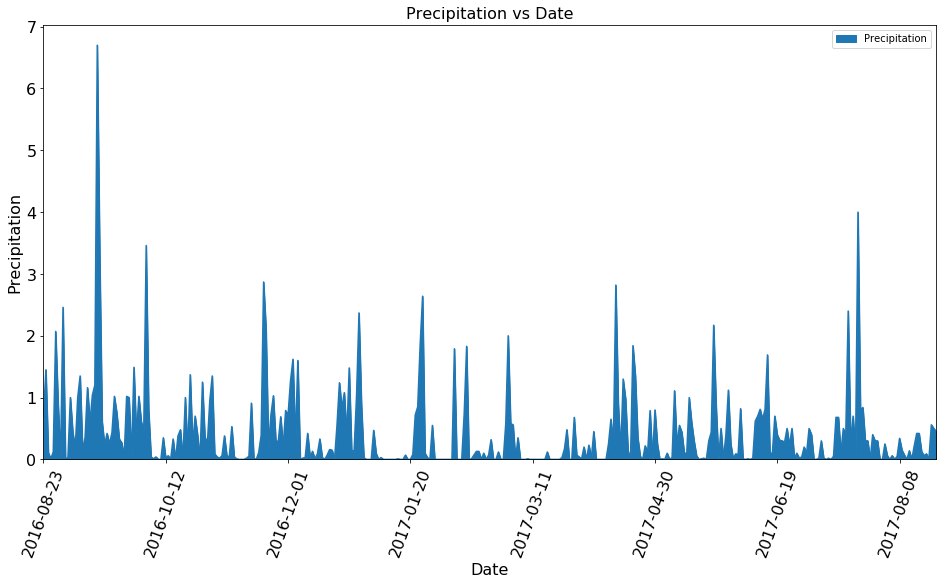

In [617]:
# Area Plot: Precipitation vs Date
Precipitation_df.plot(x = 'Date', kind = 'area', figsize = (16,8), rot = 70, fontsize = 16)
plt.title("Precipitation vs Date", fontsize = '16')
plt.xlabel("Date", fontsize = '16')
plt.ylabel("Precipitation", fontsize = '16')
plt.savefig("Precipitation vs Data.png")
plt.show()

## Station Analysis:

### Query to calculate the total number of stations

In [495]:
# Total number of stations
station_count_total = session.query(func.count(Measurement.station)).\
                      join(Station, Measurement.station == Station.station).all()
station_count_total

[(72412)]

In [496]:
# Number of stations for each 'Station Name'
station_count = session.query(func.count(Measurement.station), Measurement.station, Station.name).\
                join(Station, Measurement.station == Station.station).\
                group_by(Measurement.station).all()
station_count

[(7728, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 (10784, 'USC00513117', 'KANEOHE 838.1, HI US'),
 (7748, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 (9936, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US'),
 (2732, 'USC00517948', 'PEARL CITY, HI US'),
 (1368, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 (11088, 'USC00519281', 'WAIHEE 837.5, HI US'),
 (10740, 'USC00519397', 'WAIKIKI 717.2, HI US'),
 (10288, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US')]

### Query to find the most active stations.

#### 1. List the stations and observation counts in descending order

In [497]:
station_active = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
                 join(Station, Measurement.station == Station.station).\
                 group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
station_active

[('USC00519281', 'WAIHEE 837.5, HI US', 11088),
 ('USC00513117', 'KANEOHE 838.1, HI US', 10784),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 10740),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 10288),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 9936),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 7748),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 7728),
 ('USC00517948', 'PEARL CITY, HI US', 2732),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 1368)]

#### Which station has the highest number of observations?

In [498]:
Highest_Observations = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
                       join(Station, Measurement.station == Station.station).\
                       group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()

Highest_Observations

('USC00519281', 'WAIHEE 837.5, HI US', 11088)

In [499]:
Highest_Observations_Station = Highest_Observations[0]
Highest_Observations_Station

'USC00519281'

### Query to retrieve the last 12 months of temperature observation data (tobs).

In [500]:
station_tobs = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
               filter(Measurement.station == Highest_Observations_Station).\
               filter(Measurement.date.between('2016-08-23', '2017-08-23')).all()   

In [501]:
# Defining a DataFrame
station_tobs_df = pd.DataFrame(station_tobs, columns=['Station', 'Date', 'Observations_Count'])
station_tobs_df.head()

,Station,Date,Observations_Count
0,USC00519281,2016-08-23,77
1,USC00519281,2016-08-24,77
2,USC00519281,2016-08-25,80
3,USC00519281,2016-08-26,80
4,USC00519281,2016-08-27,75


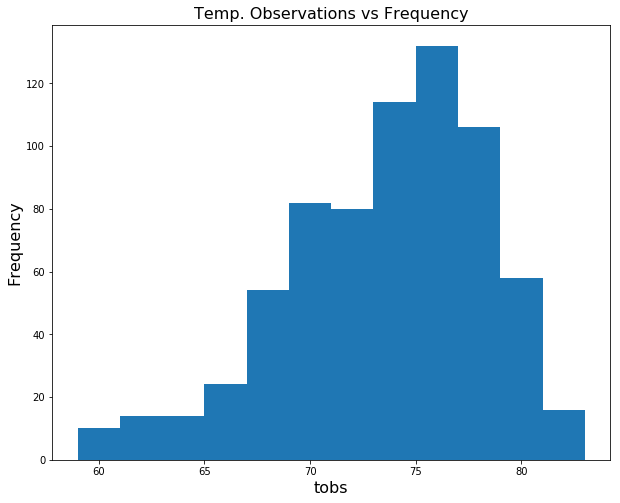

In [618]:
# Histogram for no. of Temp observations
plt.figure(figsize=(10,8))
plt.hist(station_tobs_df['Observations_Count'], bins = 12)
plt.title("Temp. Observations vs Frequency", fontsize = '16')
plt.xlabel("tobs", fontsize = '16')
plt.ylabel("Frequency", fontsize = '16')
plt.savefig("Temp.Observations vs Frequency.png")
plt.show()

### Temperature Analysis

In [619]:
#start_date = '2017-06-01'
#end_date = '2017-07-30'

In [620]:
# Defining a function
import numpy as np

def calc_temps (start_date, end_date):
    calc_station_tobs = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
                        filter(Measurement.date.between(start_date, end_date)).all()
    calc_station_tobs_df = pd.DataFrame(calc_station_tobs, columns=['Station', 'Date', 'Observations_Count'])
    tobs = calc_station_tobs_df['Observations_Count']
    min_temp = min(tobs)
    max_temp = max(tobs)
    avg_tem = np.mean(tobs)
    avg_temp = np.around(avg_tem, decimals=2)
    #return f'Min. Temp is {min_temp}F, Max. Temp is {max_temp}F, Avg. Temp is {avg_temp}F'
    return (min_temp, max_temp, avg_temp)

In [621]:
# Assigning "calc_temps (start_date, end_date)" function output to "min_temp, max_temp, avg_temp" 
min_temp, max_temp, avg_temp = calc_temps ('2017-06-01', '2017-07-30')

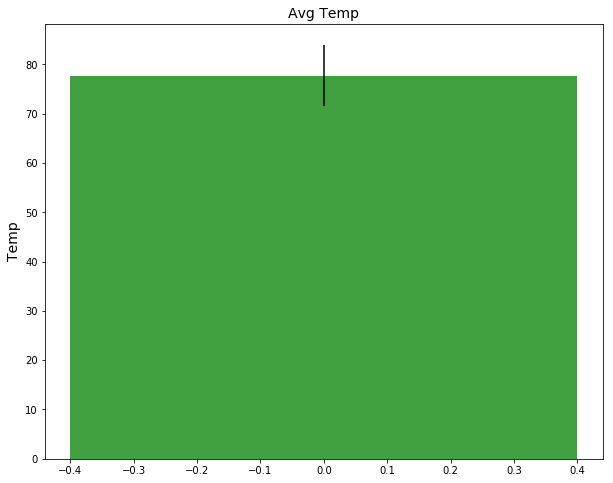

In [623]:
# Bar plot with 'yerr'
plt.figure(figsize=(10,8))
plt.bar(0, avg_temp, color='Green', alpha=.75, yerr=[max_temp - avg_temp])
plt.align = 'left'
plt.ylabel("Temp", fontsize = 14)
plt.title("Avg Temp", fontsize = 14)
plt.savefig("Avg_temp.png")
plt.show()